This model uses sequence to sequence prediction to try to learn the plantar flexion portion of a stride from the non-plantar flexion version of the stride

In [1]:
using Pkg

In [2]:
using Flux
using Flux: onehot, chunk, batchseq, throttle, crossentropy, batch
using StatsBase: wsample
using Base.Iterators: partition
using CSV
using MultivariateStats
using LinearAlgebra
using StatsBase
using Random
using BSON: @save
using Dates
using Plots
using Statistics
using DataFrames

loaded


In [3]:
# Define parameters
N_FEATURES = 1;
ALPHABET_SIZE = 200;

In [4]:
add_dim(x::Array,dim) = reshape(x, (size(x)...,1))

add_dim (generic function with 1 method)

In [5]:
prctile(x::Array,p) = sort(x)[Int(round((p/100)*length(x)))]

prctile (generic function with 1 method)

In [6]:
# Add in and process data
text = CSV.read("f1_processed_data.csv", header=0);
text = convert(Array, text);
timepts = text[:,1];
heel_strike = findall(text[:,8].==1);


cycle_time = heel_strike[2:end] .- heel_strike[1:end-1];
startPF = Int.(round.(heel_strike[1:end-1] .+ .3 .*cycle_time .- 15));
PFend = Int.(round.(heel_strike[1:end-1] .+ .6 .*cycle_time));

labels = text[:,end];
data0 = text[:,[2,3,4,5,6,7]];

SOS = 1.1;
EOS = 99.9;

means = [mean(data0[:,col]) for col in range(1,size(data0,2))];
std_data = [std(data0[:,col]) for col in range(1,size(data0,2))];
means = reshape(means,(1,6));
data0 = data0 .-means;
data0 = data0 ./ reshape(std_data, (1,6));

In [8]:
# Perform PCA to reduce the 6 dimensions down to 1

In [7]:
function customPCA(dat, num_components)
    V = StatsBase.cov(dat);
    values = eigvals(V)
    vectors = eigvecs(V)
    
    k = sortperm(values,rev=true)
    k_keep = k[1:num_components]
    data_proj = transpose(vectors[:,k_keep])*transpose(dat)
    return values, vectors, data_proj, k_keep
end

customPCA (generic function with 1 method)

In [9]:
values, vectors, data_proj, k_keep = customPCA(data0, 1);

In [12]:
# Bin data, encode into alphabet, and batch data into strides for training
data = transpose(data_proj);

mins_f = minimum(data)
BIN_STEP = (maximum(data) - minimum(data))./ALPHABET_SIZE
data = (round.((data .- mins_f)./BIN_STEP)) .+ 1;

st_idx = 1;
seqlens1 = [];
seqlens2 = [];
data_old = Array{Float64}(undef, 0, N_FEATURES)

trn_dat1 = [];
trn_dat2 = [];
trn_dat3 = [];

tst_dat1 = [];
tst_dat2 = [];
tst_dat3 = [];

alphabet = unique(data);
append!(alphabet, [SOS EOS])
data_a = map(ch -> onehot(ch, alphabet), data);
stop_idx = onehot(SOS, alphabet);

# randomize strides
sf_inds = shuffle(1:length(PFend));

data_add = [];
for i in sf_inds
    global data_add, data_n
#     # section data one way with data_n
#     global data_n
     data_n = data[st_idx:startPF[i],:]
    
     data_n=vcat(data_n, reshape(repeat([SOS],(N_FEATURES)),(1,N_FEATURES)))
     data_n = vcat(data_n, data[startPF[i]+1:PFend[i],:])
     data_n=vcat(data_n, reshape(repeat([EOS],(N_FEATURES)),(1,N_FEATURES)))
     data_n = [data_old; data_n]
     if i == length(startPF)
         data_n = [data_n; data[PFend[i]:end,:]];
     end
     data_old = copy(data_n)
    st_idx = PFend[i] +1
    if i > 1
        data_add_1 = data_n[PFend[i-1]:startPF[i]];
        data_add_2 = data_n[startPF[i]:PFend[i]-1];
        data_add_3 = data_n[startPF[i]+1:PFend[i]];
#         data_add = map(ch -> reshape(onehot(ch, alphabet),(length(alphabet),1)), data_add)
        
        append!(seqlens1, length(PFend[i-1]:startPF[i]))
        append!(seqlens2, length(startPF[i]:PFend[i]-1))
        
        # section data with data_stride
        
        if i > round(.8*length(PFend))
            append!(tst_dat1, [data_add_1])
            append!(tst_dat2, [data_add_2])
            append!(tst_dat3, [data_add_3])
        else
            append!(trn_dat1, [data_add_1])
            append!(trn_dat2, [data_add_2])
            append!(trn_dat3, [data_add_3])
        end
    end
    
end
# data_OH = map(ch -> onehot(ch, alphabet), data_n);


In [13]:
# Pad data to get same-length strides
function custom_pad(data, seqlen, pad)
    dnew = [];
    for dat in data
        if length(dat)<seqlen
#             println(fill(seqlen-length(dat), pad))
            append!(dat, fill(pad,seqlen-length(dat)));
        end
        dat = dat[1:seqlen]
        datn = map(ch -> reshape(onehot(ch, alphabet),(length(alphabet),1)), dat)
        append!(dnew, [datn])
    end
    return dnew
end

custom_pad (generic function with 1 method)

In [14]:
seqlen1 = prctile(seqlens1,75);
seqlen2 = prctile(seqlens2,75);
stop_idx = onehot(SOS, alphabet);

data1_OH = custom_pad(trn_dat1, seqlen1, SOS);
data2_OH = custom_pad(trn_dat2, seqlen2, SOS);
data3_OH = custom_pad(trn_dat3, seqlen2, SOS);

tst_data1_OH = custom_pad(tst_dat1, seqlen1, SOS);
tst_data2_OH = custom_pad(tst_dat2, seqlen2, SOS);
tst_data3_OH = custom_pad(tst_dat3, seqlen2, SOS);

In [18]:
# Run Model

data_train = collect(zip(data1_OH, data2_OH, data3_OH))

data_tst = collect(zip(tst_data1_OH, tst_data2_OH, tst_data3_OH))

using Flux: flip, crossentropy, reset!, throttle
using Flux: @epochs

phones = alphabet
Nin = length(alphabet)
Nh = 30 # size of hidden layer

forward  = LSTM(Nin, Nh÷2)
backward = LSTM(Nin, Nh÷2)

# Encode takes in tokens

encode(tokens) = vcat.(forward.(tokens), flip(backward, tokens))

alignnet = Dense(2Nh, 1)
align(s, t) = alignnet(vcat(t, s .* trues(1, size(t, 2))))

recur   = LSTM(Nh+length(phones), Nh)
toalpha = Dense(Nh, length(phones))

function asoftmax(xs)
  xs = [exp.(x) for x in xs]
  s = sum(xs)
  return [x ./ s for x in xs]
end

# decode takes in tokens and step+1 data
function decode1(tokens, phone)
  weights = asoftmax([align(recur.state[2], t) for t in tokens])    
  context = sum(map((a, b) -> a .* b, weights, tokens)) # 113 - sequence length
  y = recur(vcat(float(phone), context))
  return softmax(toalpha(y))
end

decode(tokens, phones) = [decode1(tokens, phone) for phone in phones]

# The full model

state = (forward, backward, alignnet, recur, toalpha)

function model(x, y)
  ŷ = decode(encode(x), y)
  reset!(state)
  return ŷ
end

function loss(x, y, z)
    return sum(crossentropy.(model(x, y), z))
end

# Train model

opt = ADAM(params(state), 0.01)

loss_vec= [];
test_loss_vec = [];
evalcb = throttle(30) do
    @show "Train Loss" loss(data_train[1][1], data_train[1][2], data_train[1][3])
    @show "Test Loss" loss(data_tst[1][1], data_tst[1][2], data_tst[1][3])
    append!(loss_vec, loss(data_train[1][1], data_train[1][2], data_train[1][3]))
    append!(test_loss_vec, loss(data_tst[1][1], data_tst[1][2], data_tst[1][3]))
end

@epochs 5 Flux.train!(loss, data_train, opt, cb = evalcb)

@save "seq2seq_projPCA_lr01_model_all_1212.bson" model encode decode1 opt
using JLD
save("seq2seq_projPCA_lr01Vars_1212.jld", "test_data", data_tst, "alphabet", alphabet)

# Prediction

┌ Info: Epoch 1
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 329.9528587789006 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 332.7045535809935 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 205.69711245265677 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 269.49077167944586 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 193.2286464640281 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 279.4696382670707 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 186.4783442398147 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 273.8723268171013 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1

loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 115.16131667062935 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 183.55533109032115 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 112.98919355944 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 181.78974734035359 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 116.38689960498176 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 181.06826396836226 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 115.52046089649411 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 184.50174747649888 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2]

┌ Info: Epoch 2
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 106.29343599466479 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 175.20553512800302 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 106.13179641222467 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 173.85029136006045 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 106.35766339460669 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 172.88095519614168 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 107.57173941868119 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 171.30117348936648 (tracked)
"Train Loss" = "Train Loss"
loss((data_t

loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 100.31088890468543 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 167.2474355234449 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 100.37315359908942 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 167.0112624759805 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 99.86807664991213 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 167.8790046881545 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (data_train[1])[3]) = 97.469886974963 (tracked)
"Test Loss" = "Test Loss"
loss((data_tst[1])[1], (data_tst[1])[2], (data_tst[1])[3]) = 168.23224177470027 (tracked)
"Train Loss" = "Train Loss"
loss((data_train[1])[1], (data_train[1])[2], (d

InterruptException: InterruptException:

In [ ]:
# The rest is saving and plotting

In [21]:
@save "seq2seq_projPCA_lr01_model_only_1212.bson" model opt
@save "seq2seq_projPCA_lr01_encode_1212.bson" encode
@save "seq2seq_projPCA_lr01_decode1_1212.bson" decode1

In [19]:
@save "seq2seq_projPCA_lr01_model_only_1212.bson" model opt
using JLD
save("seq2seq_projPCA_lr01Vars_1212.jld", "test_data", data_tst, "alphabet", alphabet)

Internal error: encountered unexpected error in runtime:
InterruptException()
jl_mutex_unlock at /Users/osx/buildbot/slave/package_osx64/build/src/./locks.h:138 [inlined]
jl_typeinf_end at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:2568
typeinf_ext at ./compiler/typeinfer.jl:568
typeinf_ext at ./compiler/typeinfer.jl:604
jfptr_typeinf_ext_1.clone_1 at /Applications/Julia-1.0.app/Contents/Resources/julia/lib/julia/sys.dylib (unknown line)
jl_apply at /Users/osx/buildbot/slave/package_osx64/build/src/./julia.h:1537 [inlined]
jl_apply_with_saved_exception_state at /Users/osx/buildbot/slave/package_osx64/build/src/rtutils.c:257
jl_type_infer at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:275
jl_compile_method_internal at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:1786
jl_fptr_trampoline at /Users/osx/buildbot/slave/package_osx64/build/src/gf.c:1830
do_call at /Users/osx/buildbot/slave/package_osx64/build/src/interpreter.c:324
eval_stmt_value at /Users/osx

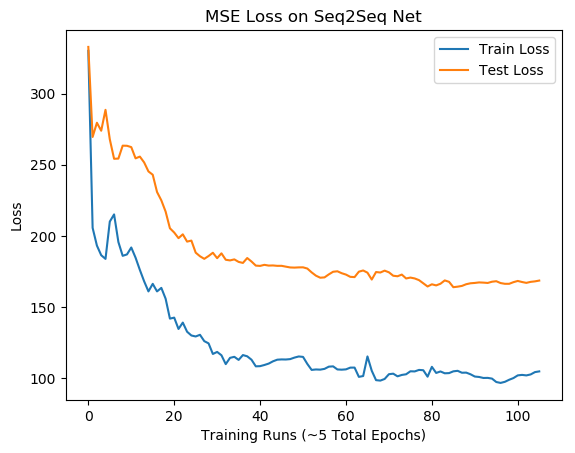

PyObject <matplotlib.legend.Legend object at 0x12ab034a8>

In [23]:
using PyPlot
loss_vec = [l.data for l in loss_vec]
test_loss_vec = [t.data for t in test_loss_vec]
PyPlot.plot(loss_vec, label = "Train Loss")
PyPlot.plot(test_loss_vec, label= "Test Loss")
xlabel("Training Runs (~5 Total Epochs)")
ylabel("Loss")
title("MSE Loss on Seq2Seq Net")
legend(loc="upper right",fancybox="true")

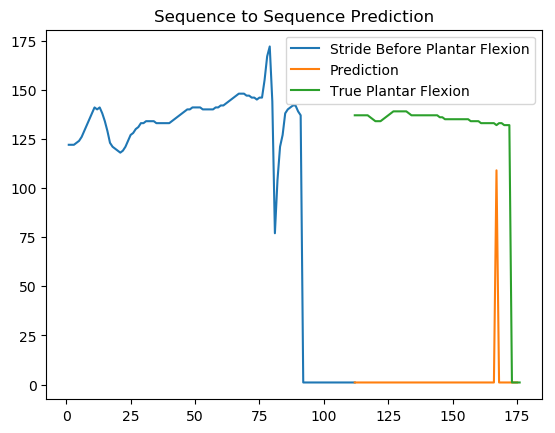

In [95]:
using StatsBase: wsample
model = cpu(model)
function predict(alphabet, primer)
  ts = encode(primer)
  ps=[];
  for i = 1:seqlen2
    dist = decode1(ts, primer[end])
    next = wsample(alphabet, vec(Tracker.data(dist)))
    append!(ps, next)
  end
  return ps[2:end]
    
end

# shuffle_vec = shuffle(1:length(tst_data1_OH));
primer_vec = [];
buffer_vec = [];
truths_vec = [];

# for i in 1
i = 10;
# idx = shuffle_vec[i];
idx = 107;
primer = tst_data1_OH[idx][1:end-1];
buffer = predict(alphabet, primer);
truths = tst_dat3[idx];
#     both = [primer buffer]
PyPlot.plot(1:length(primer), tst_dat1[idx][1:length(primer)], label="Stride Before Plantar Flexion")
PyPlot.plot(length(primer):length(primer)+length(buffer)-1, buffer, label="Prediction")
PyPlot.plot(length(primer):length(primer)+length(truths)-1, truths, label="True Plantar Flexion")
legend()
title("Sequence to Sequence Prediction")

save("seq2seq_vecsEX_111.jld", "primer_vec", tst_dat1[idx][1:length(primer)], "buffer_vec", buffer_vec, "truths_vec",truths)

In [193]:
function customRecon(new_data, eigenvecs, k_keep)
    if length(size(new_data))==1
        new_data = reshape(new_data, (length(new_data),1));
    end
    recon = eigenvecs[:,k_keep]*(transpose(new_data))
    return transpose(recon)
end
    

customRecon (generic function with 1 method)

In [194]:
recon_data = customRecon(buffer, vectors, k_keep);
recon_data_true = customRecon(tst_dat1[sample_space], vectors, k_keep);

In [195]:
using Plots

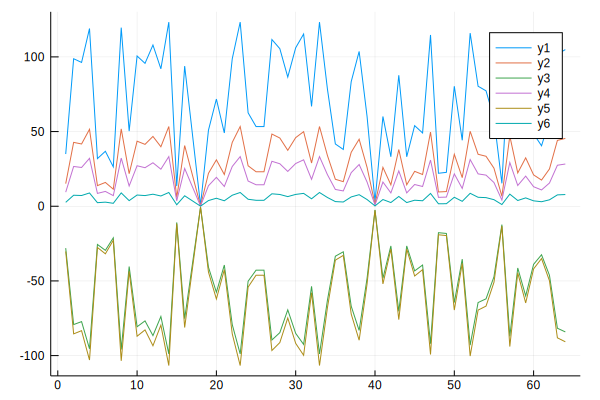

In [196]:
plot(recon_data[:,1])
plot!(recon_data[:,2])
plot!(recon_data[:,3])
plot!(recon_data[:,4])
plot!(recon_data[:,5])
plot!(recon_data[:,6])

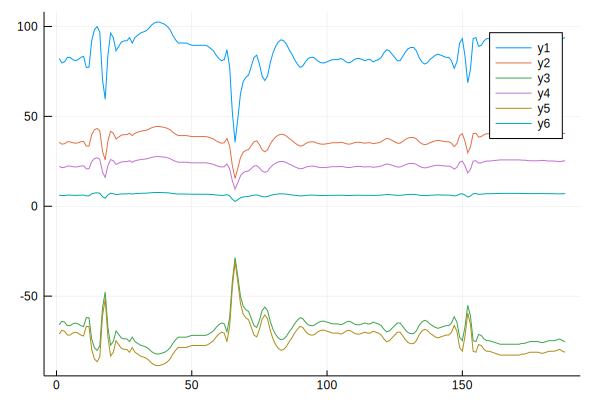

In [197]:
plot(recon_data_true[:,1])
plot!(recon_data_true[:,2])
plot!(recon_data_true[:,3])
plot!(recon_data_true[:,4])
plot!(recon_data_true[:,5])
plot!(recon_data_true[:,6])

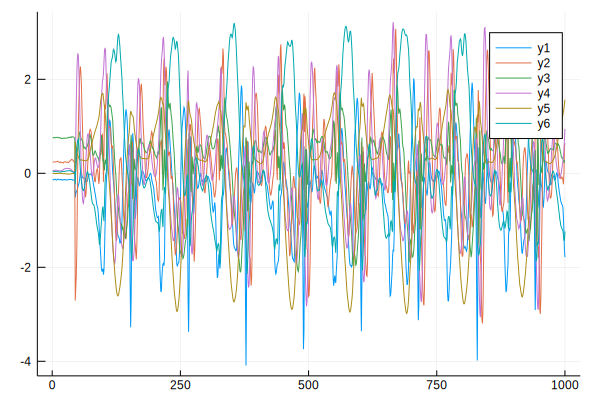

In [82]:
plot(data0[1:1000,1])
plot!(data0[1:1000,2])
plot!(data0[1:1000,3])
plot!(data0[1:1000,4])
plot!(data0[1:1000,5])
plot!(data0[1:1000,6])